In [13]:
import os
import shutil
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [14]:
plant_village_dir = "/kaggle/input/plantvillage-dataset/color"
plant_doc_dir = "/kaggle/input/plantdoc-dataset/train"
dataset_dir = "/kaggle/working/dataset/"

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

batch_size = 32

In [2]:

from tensorflow.keras.applications import ResNet50
# Load pre-trained ResNet-50 model without the top (fully connected) layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained ResNet-50 layers
for layer in resnet_base.layers:
    layer.trainable = True

# Create the rest of your model
model = keras.Sequential([
    keras.layers.Rescaling(scale=1/255, input_shape=(224, 224, 3)),
    
    resnet_base,
    
    keras.layers.GlobalAveragePooling2D(),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(38, activation='sigmoid')
])

model.summary()

2024-02-21 06:30:43.057950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 06:30:43.058046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 06:30:43.192999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


94765736/94765736 [==============================] - 4s 0us/step


NameError: name 'keras' is not defined

In [16]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can use other metrics like 'val_accuracy'
    patience=5,          # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore the best model weights when early stopping
)

In [6]:
print(os.listdir("/kaggle/input/plantvillage-dataset"))


print(len(os.listdir("/kaggle/input/plantvillage-dataset/color")))
print(os.listdir("/kaggle/input/plantvillage-dataset/color")[:5])


['segmented', 'grayscale', 'plantvillage dataset', 'color']
38
['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy']


In [7]:
print(len(os.listdir("/kaggle/input/plantvillage-dataset/color/Apple___Apple_scab")))
print(os.listdir("/kaggle/input/plantvillage-dataset/color/Apple___Apple_scab")[:5])

630
['5a178d63-372d-48c4-adb8-d616130ba3f0___FREC_Scab 3104.JPG', '8bcbb4fb-c733-4fc7-92d2-6e4a442e592e___FREC_Scab 3506.JPG', '2bc018ba-3c49-4cf4-9411-a93b7b196f45___FREC_Scab 3326.JPG', 'f18c0441-917e-4f34-b26e-a1a71d0adec2___FREC_Scab 3429.JPG', 'bc7769cc-805e-42ef-bbcf-0c134ff03276___FREC_Scab 2909.JPG']


In [8]:
base_dir = '/kaggle/input/plantvillage-dataset/color'

In [18]:
train_ds, test_ds = keras.utils.image_dataset_from_directory(
    plant_village_dir ,
    image_size=(224,224),
    batch_size=32,
    seed = 123,
    validation_split=.2,
    subset='both'
)

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Using 10861 files for validation.


In [19]:
history = model.fit(train_ds, epochs=6, validation_data=test_ds, callbacks=[early_stopping])

Epoch 1/6


I0000 00:00:1708468072.994745      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1358/1358 [==============================] - 308s 198ms/step - loss: 1.3055 - accuracy: 0.6576 - val_loss: 0.3616 - val_accuracy: 0.8857
Epoch 2/6
1358/1358 [==============================] - 256s 188ms/step - loss: 0.3971 - accuracy: 0.8869 - val_loss: 0.6744 - val_accuracy: 0.8191
Epoch 3/6
1358/1358 [==============================] - 255s 188ms/step - loss: 0.2440 - accuracy: 0.9314 - val_loss: 0.3180 - val_accuracy: 0.9043
Epoch 4/6
1358/1358 [==============================] - 255s 188ms/step - loss: 0.1665 - accuracy: 0.9538 - val_loss: 0.2015 - val_accuracy: 0.9412
Epoch 5/6
1358/1358 [==============================] - 255s 188ms/step - loss: 0.1250 - accuracy: 0.9654 - val_loss: 0.0796 - val_accuracy: 0.9737
Epoch 6/6
1358/1358 [==============================] - 268s 197ms/step - loss: 0.0955 - accuracy: 0.9742 - val_loss: 0.1003 - val_accuracy: 0.9693


In [20]:
predictions = model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = [label for _, label in test_ds.unbatch()]
print(classification_report(true_labels, predicted_labels))

340/340 [==============================] - 20s 54ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       120
           1       0.94      0.99      0.96       124
           2       1.00      0.96      0.98        56
           3       0.97      1.00      0.98       348
           4       1.00      0.98      0.99       318
           5       1.00      1.00      1.00       208
           6       0.84      1.00      0.92       147
           7       0.88      0.87      0.88       109
           8       1.00      1.00      1.00       238
           9       0.93      0.94      0.93       200
          10       1.00      1.00      1.00       247
          11       0.97      1.00      0.98       229
          12       1.00      0.98      0.99       274
          13       1.00      0.85      0.92       219
          14       0.97      1.00      0.98        94
          15       1.00      0.99      1.00      1137
          16       0.99 

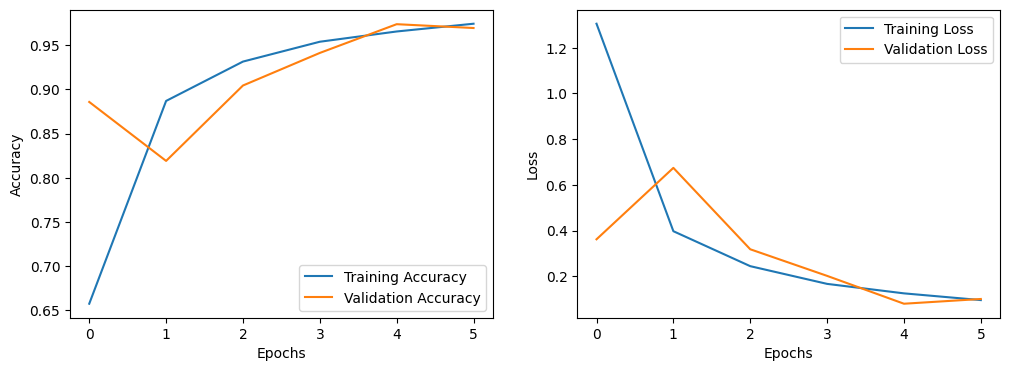

In [21]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
history = model.fit(train_ds, epochs=2, validation_data=test_ds, callbacks=[early_stopping])


Epoch 1/2
1358/1358 [==============================] - 256s 188ms/step - loss: 0.0693 - accuracy: 0.9810 - val_loss: 0.1204 - val_accuracy: 0.9642
Epoch 2/2
1358/1358 [==============================] - 255s 188ms/step - loss: 0.0517 - accuracy: 0.9864 - val_loss: 0.1508 - val_accuracy: 0.9583


In [24]:
history = model.fit(train_ds, epochs=1, validation_data=test_ds, callbacks=[early_stopping])

1358/1358 [==============================] - 256s 188ms/step - loss: 0.0385 - accuracy: 0.9898 - val_loss: 0.1529 - val_accuracy: 0.9642


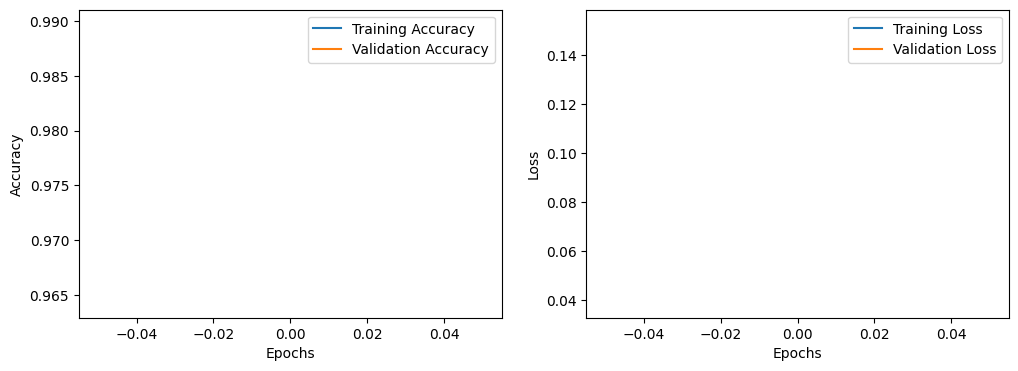

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [1]:
history = model.fit(train_ds, epochs=4, validation_data=test_ds, callbacks=[early_stopping])

NameError: name 'model' is not defined